In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v1 (KerasLayer)    (None, 1001)              6633209   
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


In [5]:
def load_imagenet_labels(file_path):
    labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

In [6]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

In [7]:
def read_image(file_name):
    image = tf.io.read_file(file_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

In [8]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

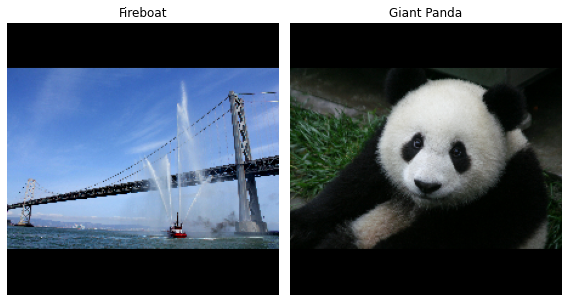

In [9]:
plt.figure(figsize=(8,8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
    ax = plt.subplot(1, 2, n+1)
    ax.imshow(img_tensors)
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()

In [10]:
def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    predictions = model(image_batch)
    probs = tf.nn.softmax(predictions, axis=-1)
    top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_probs[0]

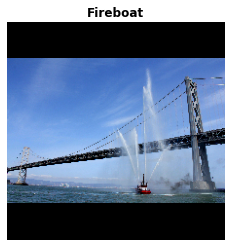

fireboat: 32.6%
pier: 12.7%
suspension bridge: 5.7%


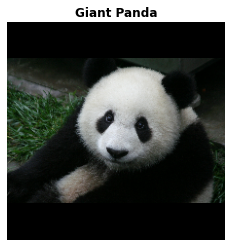

giant panda: 89.4%
teddy: 0.3%
gibbon: 0.3%


In [11]:
for (name, img_tensor) in img_name_tensors.items():
    plt.imshow(img_tensor)
    plt.title(name, fontweight='bold')
    plt.axis('off')
    plt.show()
    
    pred_label, pred_prob = top_k_predictions(img_tensor)
    for label, prob in zip(pred_label, pred_prob):
        print(f'{label}: {prob:0.1%}')

In [12]:
def f(x):
    return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
    return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

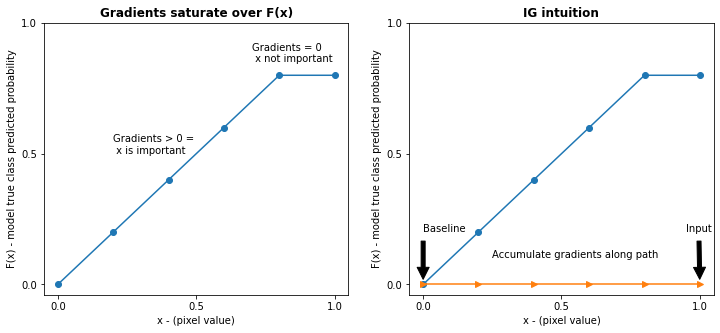

In [13]:
fig = plt.figure(figsize=(12,5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show()

<ul>
    <li>
        <b>left:</b> Your model's gradients for pixel x are positive between 0.0 and 0.8 but go to 0.0 between 0.8 and 1.0. Pixel x clearly has a significant impact on pushing your model toward 80% predicted probability on the true class. Does it make sense that pixel x's importance is small or discontinuous?
    </li>
    <li>
        <b>right:</b> The intuition behind IG is to accumulate pixel x's local gradients and attribute its importance as a score for how much it adds or subtracts to your model's overall output class probability. You can break down and compute IG in 3 parts:
    <ol>
        <li>interpolate small steps along a straight line in the feature space between 0 (a baseline or starting point) and 1 (input pixel's value)</li>
        <li>compute gradients at each step between your model's predictions with respect to each step</li>
        <li>approximate the integral between your baseline and input by accumulating (cumulative average) these local gradients.</li>
    </ol>
    </li>
</ul>

In [14]:
baseline = tf.zeros(shape=(224, 224, 3))

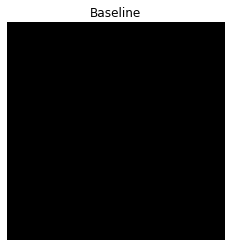

In [15]:
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [16]:
m_steps = 50
alphas = tf.linspace(start=0.0, stop=1.0, num = m_steps+1)

In [17]:
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x + alphas_x * delta
    return images

In [18]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['Fireboat'],
    alphas = alphas)

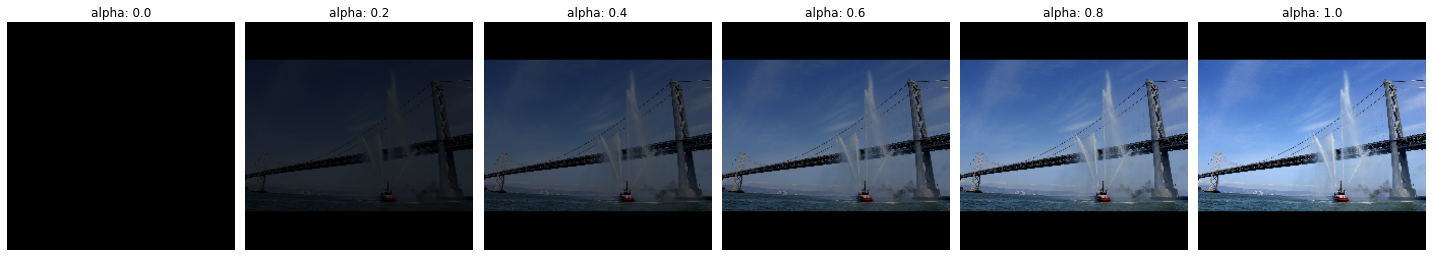

In [19]:
fig = plt.figure(figsize=(20,20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image)
    plt.axis('off')
    
plt.tight_layout();

In [20]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

In [21]:
with tf.device('cpu'):
    path_gradients = compute_gradients(
        images=interpolated_images,
        target_class_idx=555)

In [22]:
print(path_gradients.shape)

(51, 224, 224, 3)


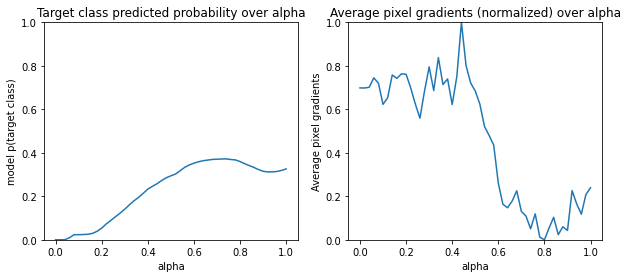

In [23]:
with tf.device('cpu'):
    pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 555]

plt.figure(figsize=(10,4))
ax1 = plt.subplot(1,2,1)
ax1.plot(alphas,pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0,1])

ax2 = plt.subplot(1,2,2)
average_grads = tf.reduce_mean(path_gradients, axis=[1,2,3])
average_grads_norm = (average_grads - tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads) - tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0,1]);

In [24]:
def integral_approximation(gradients):
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [25]:
with tf.device('cpu'):
    ig = integral_approximation(gradients=path_gradients)

In [26]:
print(ig.shape)

(224, 224, 3)


In [27]:
@tf.function
def integrated_gradients(baseline, image, target_class_idx, m_steps=50, batch_size=32):
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_ : to]
        
        interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                           image=image,
                                                           alphas=alpha_batch)
        gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                          target_class_idx=target_class_idx)
        gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)
        
    total_gradients = gradient_batches.stack()
    avg_gradients = integral_approximation(gradients=total_gradients)
    integrated_gradients = (image - baseline) * avg_gradients
    return integrated_gradients

In [28]:
with tf.device('cpu'):
    ig_attributions = integrated_gradients(baseline = baseline,
                                           image=img_name_tensors['Fireboat'],
                                           target_class_idx=555,
                                           m_steps=240)

In [29]:
print(ig_attributions.shape)

(224, 224, 3)


In [30]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=40,
                          cmap=None,
                          overlay_alpha=0.4):
    attributions = integrated_gradients(baseline = baseline,
                                        image=image,
                                        target_class_idx = target_class_idx,
                                        m_steps = m_steps)
    
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
    
    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8,8))
    
    axs[0,0].set_title('Baseline image')
    axs[0,0].imshow(baseline)
    axs[0,0].axis('off')
    
    axs[0,1].set_title('Original image')
    axs[0,1].imshow(image)
    axs[0,1].axis('off')
    
    axs[1,0].set_title('Attribution mask')
    axs[1,0].imshow(attribution_mask, cmap=cmap)
    axs[1,0].axis('off')
    
    axs[1,1].set_title('Overlay')
    axs[1,1].imshow(attribution_mask, cmap=cmap)
    axs[1,1].imshow(image, alpha=overlay_alpha)
    axs[1,1].axis('off')
    
    plt.tight_layout()
    return fig

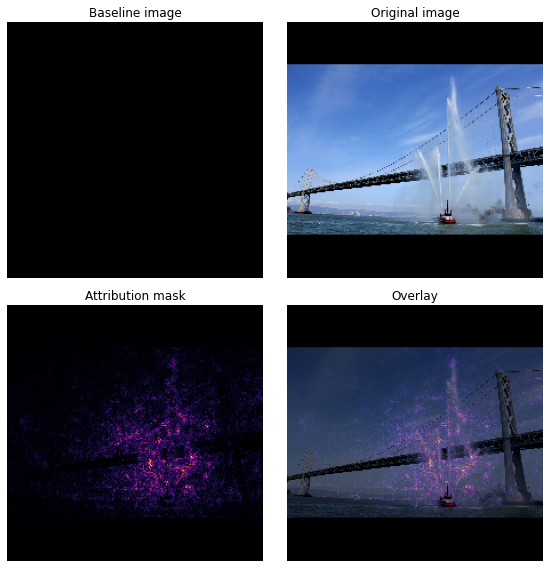

In [31]:
with tf.device('cpu'):
    _ = plot_img_attributions(image=img_name_tensors['Fireboat'],
                             baseline=baseline,
                             target_class_idx=555,
                             m_steps=240,
                             cmap=plt.cm.inferno,
                             overlay_alpha=0.4)

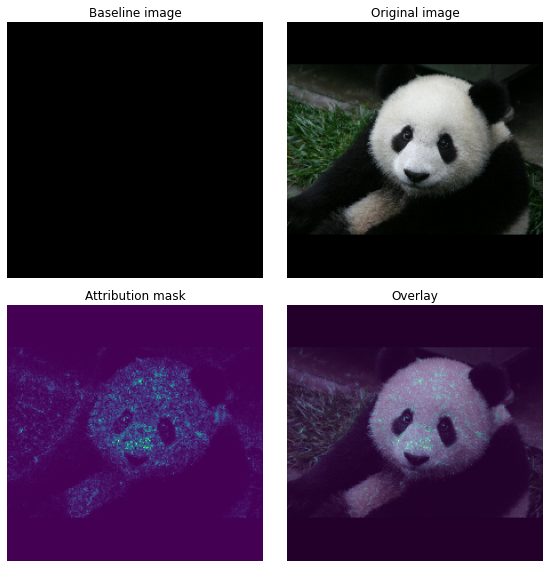

In [32]:
with tf.device('cpu'):
    _ = plot_img_attributions(image=img_name_tensors['Giant Panda'],
                             baseline=baseline,
                             target_class_idx=389,
                             m_steps=55,
                             cmap=plt.cm.viridis,
                             overlay_alpha=0.5)